<a href="https://colab.research.google.com/github/JesseTNRoberts/Do-Language-Models-Have-Rational-Preference/blob/main/Population_Prisoners_Dilemma_Preference_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
!pip install researchpy
import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install nbformat --upgrade
# !pip install seaborn --upgrade

In [2]:
# Assuming your CSV file is named "data.csv"
from google.colab import drive
drive.mount('/content/drive')
loc = "/content/drive/MyDrive/Data/"

models = [
          # 'distilbert-base-uncased',
          # 'bert-base-uncased',
          # 'bert-large-uncased',
          # 'roberta-base',
          # 'roberta-large',
          # 'xlm-roberta-large',
          # 'electra-large-generator',
          # 'openai-gpt', 'distilgpt2',
          # 'gpt2',
          # 'gpt2-medium',
          # 'open_llama_13b',
          'llama-2-7b',
          # 'llama-2-13b',
          # 'alpaca-7b',
          'Mistral-7B-v0.1',
          'gemma-7b',
          'SOLAR-10.7B-v1.0',
          # 'phi-2',
          ]

Mounted at /content/drive


In [3]:
def get_df(loc, select_reduction=1):

  df = pd.read_csv(loc)

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(lambda x: x.replace('nan', '0'))
  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)
  df.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)



  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
      axis=1)

  df['rank'] = df['rank'].astype('float')
  df['item'] = df['item'].astype('string')


  df['experiment'] = df['preamble'].apply(lambda x: x[0:-32])
  df['experiment'] = df.groupby('experiment').ngroup()+1

  df = df.explode('population data')
  df['member id'] = df.groupby(['item', 'preamble','category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')

  rosch_val = 'rank'
  # rosch_val = 'label'
  # rosch_val = 'experiment'


  df['normalized'] = df.groupby(['category',rosch_val])['population data'].transform(lambda x: x/np.mean(x))

  return df


In [127]:
# loop through all models and calculate the per category correlation and significance with typicality
import plotly.graph_objects as go

prob_results = pd.DataFrame()
std_results = {}
all = pd.DataFrame()

exp = 'prisoners'

for model in models:

  df = get_df(loc+'rational/'+exp+'/'+model+".csv")
  df['model'] = model
  base_df = get_df(loc+'rational/'+ exp +'/base/'+model+".csv")
  base_df['model'] = model

  all = pd.concat([all, df])

  rosch_val = 'rank'
  # rosch_val = 'label'
  # rosch_val = 'experiment'

  # std = df.groupby(['category',rosch_val]).aggregate({'normalized':np.std})
  # std['means'] = df.groupby(['category',rosch_val])['normalized'].mean()
  # std = std.reset_index()


  test = 'spearman'
  # test = 'pearson'
  # test = 'kendall'

  categories = ['best','worst']




In [146]:
from scipy.stats import wilcoxon
test = all.groupby(['model','category'])[['population data','item','rank']]
for item in test:
  this = item[1]
  print(item[0])
  print(wilcoxon(this[this['item']=='option1']['population data'], this[this['item']=='option2']['population data'], alternative='greater'))
  print(wilcoxon(this[this['item']=='option1']['population data'], this[this['item']=='option2']['population data'], alternative='less'))
  print(this[['population data','rank']].corr(method='kendall'))
  print('\n\n')

('Mistral-7B-v0.1', 'best')
WilcoxonResult(statistic=1274.0, pvalue=1.7763568394002505e-15)
WilcoxonResult(statistic=1274.0, pvalue=0.9999999999999991)
                 population data      rank
population data         1.000000  0.705552
rank                    0.705552  1.000000



('Mistral-7B-v0.1', 'worst')
WilcoxonResult(statistic=328.0, pvalue=0.9988618874450745)
WilcoxonResult(statistic=328.0, pvalue=0.001178403572124509)
                 population data     rank
population data          1.00000  0.45426
rank                     0.45426  1.00000



('SOLAR-10.7B-v1.0', 'best')
WilcoxonResult(statistic=1275.0, pvalue=8.881784197001252e-16)
WilcoxonResult(statistic=1275.0, pvalue=1.0)
                 population data      rank
population data         1.000000  0.707258
rank                    0.707258  1.000000



('SOLAR-10.7B-v1.0', 'worst')
WilcoxonResult(statistic=646.0, pvalue=0.46949610865559155)
WilcoxonResult(statistic=646.0, pvalue=0.5343081450216154)
                 pop

<ipython-input-215-887e07ef2bb8>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['rank'] = 3-temp['rank']
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

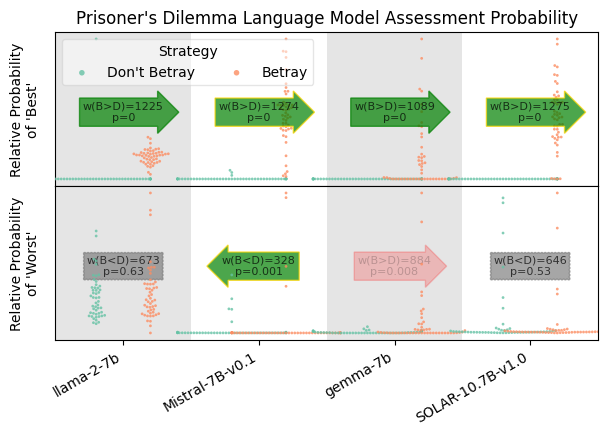

In [215]:


fig, axarr = plt.subplots(2, figsize=(12,4), sharex=True, gridspec_kw={'height_ratios': [2, 2]})

# function to alternate background color
def alt_bands(ax=None, highlight = None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    count = 0
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        if count == highlight:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
        else:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
        count+= 1
    ax.set_xlim(x_left, x_right)


plt.margins(x=0.01)
plt.subplots_adjust(hspace = 0)

# First plot
small = 0
axarr[small].tick_params(bottom=False)
axarr[small].title.set_text("Prisoner's Dilemma Language Model Assessment Probability")

temp = all[all['member id']>0]
this = temp.groupby(['model','category','rank','member id'])['population data'].mean().reset_index()

test = this.groupby(['model','category'])['population data'].min().reset_index()
test['min'] = test['population data']
test['max'] = this.groupby(['model','category'])['population data'].max().reset_index()['population data']
test = test.drop('population data', axis='columns')
test = this.merge(test, how='right')

this['population data'] = (test['population data'] - test['min'])/(test['max'] - test['min'])

that = temp.groupby(['model','category','rank','member id'])['params'].first().reset_index()
this = this.merge(that, how='right')


sns.swarmplot(x='model', # Group labels
              y='population data', # Numeric variable
              palette='Set2', # Color set used
              hue='rank', # Add a legend
              size=2,
              data=this[this['category']=='best'].sort_values(by='params'),
              dodge=True,
              ax = axarr[small],
              alpha=0.8
             )


axarr[small].set_ylabel("Relative Probability\nof 'Best'")
axarr[small].set(yticklabels=[])
axarr[small].tick_params(left=False)
axarr[small].legend(labels=["Don't Betray", "Betray"], title='Strategy', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1),ncol=2, markerscale=2)

ann_height = 0.4
size = 8

axarr[small].annotate('w(B>D)=1225\np=0',
                  xy=(-0.25, ann_height), xycoords='data', alpha=0.7,
                  xytext=(0, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'rarrow', 'fc': 'green', 'ec': 'green', 'alpha':0.7})

axarr[small].annotate('w(B>D)=1274\np=0',
                  xy=(0.75, ann_height), xycoords='data', alpha=0.7,
                  xytext=(1, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'rarrow', 'fc': 'green', 'ec': 'gold', 'alpha':0.7})

axarr[small].annotate('w(B>D)=1089\np=0',
                  xy=(1.75, ann_height), xycoords='data', alpha=0.7,
                  xytext=(2, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'rarrow', 'fc': 'green', 'ec': 'green', 'alpha':0.7})

axarr[small].annotate('w(B>D)=1275\np=0',
                  xy=(2.75, ann_height), xycoords='data', alpha=0.7,
                  xytext=(3, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'rarrow', 'fc': 'green', 'ec': 'gold', 'alpha':0.7})



# second plot
small = 1

temp = this[this['category']=='worst']
temp['rank'] = 3-temp['rank']
sns.swarmplot(x='model', # Group labels
              y='population data', # Numeric variable
              palette='Set2', # Color set used
              hue='rank', # Add a legend
              size=2,
              data=temp.sort_values(by='params'),
              dodge=True,
              ax = axarr[small],
              legend=None,
              zorder=100,
              alpha=0.8
             )

# axarr[small].title.set_text('Model Assessment Probability vs Strategy Point Value')

axarr[small].set_ylabel("Relative Probability\nof 'Worst'")
axarr[small].set(yticklabels=[])
axarr[small].tick_params(left=False)
# axarr[small].legend(labels=["Push", "Don't Push"], title='Strategy', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1),ncol=2, markerscale=2)

plt.xticks(rotation=30, ha="right")

alt_bands(axarr[0], highlight=9)
alt_bands(axarr[1], highlight=9)
# alt_bands(axarr[2], highlight=8)


axarr[small].annotate('w(B<D)=673\np=0.63',
                  xy=(-0.25, ann_height), xycoords='data', alpha=0.7,
                  xytext=(0, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'roundtooth', 'fc': 'gray', 'ec': 'gray', 'alpha':0.7})

axarr[small].annotate('w(B<D)=328\np=0.001',
                  xy=(0.75, ann_height), xycoords='data', alpha=0.7,
                  xytext=(1, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'larrow', 'fc': 'green', 'ec': 'gold', 'alpha':0.7})

axarr[small].annotate('w(B>D)=884\np=0.008',
                  xy=(1.75, ann_height), xycoords='data', alpha=0.2,
                  xytext=(2, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'rarrow', 'fc': 'red', 'ec': 'red', 'alpha':0.2})

axarr[small].annotate('w(B<D)=646\np=0.53',
                  xy=(2.75, ann_height), xycoords='data', alpha=0.7,
                  xytext=(3, ann_height), textcoords='data',
                  size=size, va="bottom", ha="center",
                  bbox={'boxstyle': 'roundtooth', 'fc': 'gray', 'ec': 'gray', 'alpha':0.7})

axarr[small].set(xlabel=None)
fig.set_size_inches(7,4)

plt.show()


